In [1]:
%matplotlib inline
import math

import matplotlib.pyplot as plt
import numpy as np
from gym import spaces
from gym_miniworld import entity
from gym_miniworld.miniworld import MiniWorldEnv
from stable_baselines3.common.vec_env.base_vec_env import tile_images

plt.rcParams['figure.figsize'] = [16, 12]

OBS_WIDTH = 26
OBS_HEIGHT = 26

In [2]:
Ball = entity.Ball
Key = entity.Key
        
class Box(entity.Box):
    def __init__(self, color, size=0.6):
        super().__init__(color, size)

class Barrel(entity.MeshEnt):
    def __init__(self, size=0.6):
        super().__init__(mesh_name="barrel", height=size, static=True)


class Chair(entity.MeshEnt):
    def __init__(self, size=0.6):
        super().__init__(mesh_name="office_chair", height=size, static=True)


class Cone(entity.MeshEnt):
    def __init__(self, size=0.6):
        super().__init__(mesh_name="cone", height=size, static=True)


class Duckie(entity.MeshEnt):
    def __init__(self, size=0.6):
        super().__init__(mesh_name="duckie", height=size, static=True)


class KeyCard(entity.MeshEnt):
    def __init__(self, size=0.6):
        super().__init__(mesh_name="keycard", height=size, static=True)


class MedKit(entity.MeshEnt):
    def __init__(self, size=0.6):
        super().__init__(mesh_name="medkit", height=size, static=True)


class Potion(entity.MeshEnt):
    def __init__(self, size=0.6):
        super().__init__(mesh_name="potion", height=size, static=True)

In [3]:
class ObjInFront(MiniWorldEnv):
    """Room with one object in from of the agent."""

    def __init__(self, obj_type, **kwargs):
        self.obj_type = obj_type

        super().__init__(domain_rand=True, **kwargs)
        
        # Reduce the action space
        self.action_space = spaces.Discrete(0)

    def _gen_world(self):
        textures = ["asphalt", "brick_wall", "cardboard", "ceiling_tile_noborder", "ceiling_tiles",
                    "cinder_blocks", "concrete", "concrete_tiles", "drywall", "floor_tiles_bw",
                    "grass", "lava", "marble", "metal_grill", "rock", "slime", "stucco", "water",
                    "wood", "wood_planks"]
        floor_tex = self.rand.choice(textures)
        wall_tex = self.rand.choice(textures)
        ceil_tex = self.rand.choice(textures)
        no_ceiling = self.rand.bool()
        
        self.add_rect_room(
            min_x=-5,
            max_x=5,
            min_z=-5,
            max_z=5,
            floor_tex=floor_tex,
            wall_tex=wall_tex,
            ceil_tex=ceil_tex,
            no_ceiling=no_ceiling,
        )

        self._direction = self.rand.float(-math.pi, math.pi)
        self._distance = self.rand.float(1.0, 2.0)
        self._position = [
            self._distance * math.cos(self._direction),
            1,
            self._distance * math.sin(self._direction),
        ]

        if self.obj_type == Box or self.obj_type == Ball or self.obj_type == Key:
            self.place_entity(self.obj_type(color=self.rand.color()), pos=self._position)
        else:
            self.place_entity(self.obj_type(), pos=self._position)

        self.place_entity(self.agent, pos=[0, 0, 0], dir=-self._direction + self.rand.float(-0.3, 0.3))
        
obj_types = [Ball, Barrel, Box, Chair, Cone, Duckie, Key, KeyCard, MedKit, Potion]

In [4]:
train_frames = np.zeros([1000, OBS_HEIGHT, OBS_WIDTH, 3], dtype=np.uint8)
train_labels = np.zeros([1000,], dtype=np.int64)
test_frames = np.zeros([200, OBS_HEIGHT, OBS_WIDTH, 3], dtype=np.uint8)
test_labels = np.zeros([200,], dtype=np.int64)

In [5]:
NUM_TRAIN_SAMPLES_PER_OBJ = train_frames.shape[0] // len(obj_types)
NUM_TEST_SAMPLES_PER_OBJ = test_frames.shape[0] // len(obj_types)
for idx, obj_type in enumerate(obj_types):
    env = ObjInFront(obj_type=obj_type, obs_height=train_frames.shape[1], obs_width=train_frames.shape[2])

    for i in range(NUM_TRAIN_SAMPLES_PER_OBJ * idx, NUM_TRAIN_SAMPLES_PER_OBJ * (idx + 1)):
        train_frames[i] = env.reset()
        train_labels[i] = idx
        
    for j in range(NUM_TEST_SAMPLES_PER_OBJ * idx, NUM_TEST_SAMPLES_PER_OBJ * (idx + 1)):
        test_frames[j] = env.reset()
        test_labels[j] = idx

Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer
Falling back to non-multisampled frame buffer


array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9])

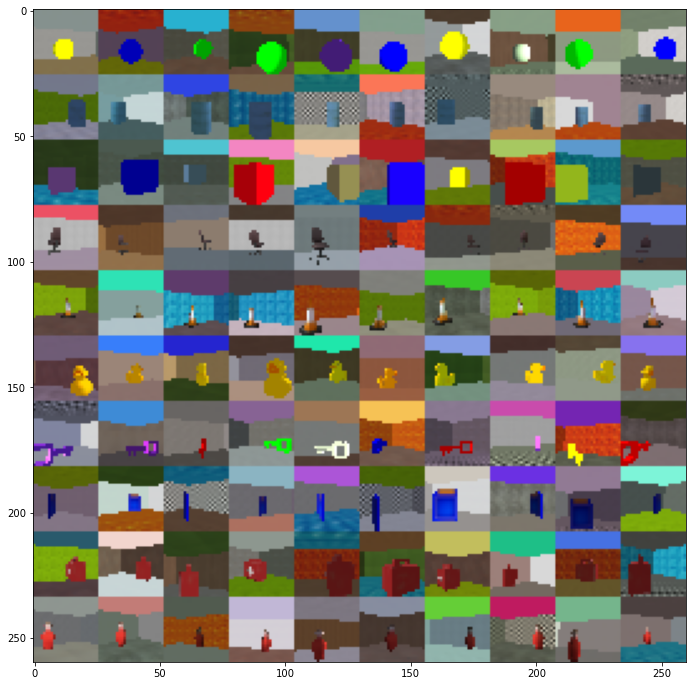

In [6]:
img = tile_images(train_frames[::10])
plt.imshow(img)
train_labels[::25]

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9])

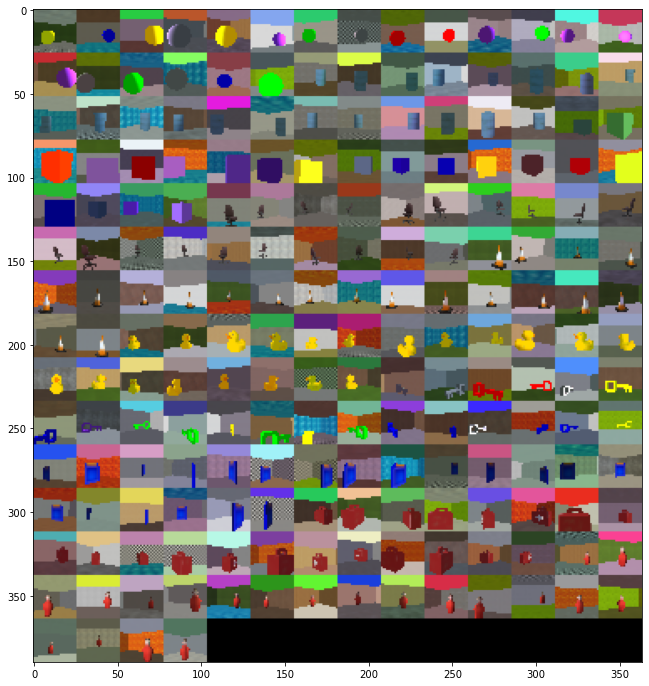

In [7]:
img = tile_images(test_frames)
plt.imshow(img)
test_labels[::5]

In [8]:
np.savez('lookatobjs_dataset.npz', train_frames=train_frames, train_labels=train_labels, test_frames=test_frames, test_labels=test_labels)